## VGG16

In [19]:
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [21]:
img_width, img_height = 224, 224
train_data_dir = './CNN/data/train'
# train_data_dir = os.path.join(os.getcwd(), 'test')
validation_data_dir = './data/validation'
nb_train_samples = 1000
nb_validation_samples = 1000
epochs = 5
batch_size = 200
input_shape = (img_height, img_width, 3)
num_classes = 2 # 類別個數

# Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights = 'imagenet', include_top = False)
model_vgg16_conv.summary()

# Create your own input format (here224x224x3)
input = Input(shape = (img_width, img_height, 3), name = 'image_input')

# Use the generated model
output_vgg16_conv = model_vgg16_conv(input)

# Add the fully-connected layers
x = Flatten(name = 'flatten')(output_vgg16_conv)
# x = Dense(4096, activation = 'relu', name = 'fc1')(x)
x = Dense(256, activation = 'relu', name = 'fc2')(x)
x = Dense(num_classes, activation = 'softmax', name = 'predictions')(x)

# Create your own model
model = Model(input, x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model.summary()
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.SGD(learning_rate = 1e-4, momentum = 0.9),
              metrics = ['accuracy'])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# 跳過訓練步驟

In [22]:
from keras.models import load_model
from keras.preprocessing import image
import os
import numpy as np
from keras.applications.vgg16 import preprocess_input

model = load_model("./myvgg16.h5")

img_path = 'cat.0.jpg'
img = image.load_img(img_path, target_size = (224, 224))
x1 = image.img_to_array(img)
x1 = np.expand_dims(x1, axis = 0)
x1 = preprocess_input(x1)

predictions = model.predict(x1)
print('predict:', predictions.ravel())

predict: [1.0000000e+00 3.1769695e-11]


In [23]:
img_path = 'dog.3.jpg'
img = image.load_img(img_path, target_size = (224, 224))
x1 = image.img_to_array(img)
x1 = np.expand_dims(x1, axis = 0)
x1 = preprocess_input(x1)

predictions = model.predict(x1)
print('predict:', predictions.ravel())

predict: [4.2368105e-35 1.0000000e+00]


## Cosine Similarity
算出所有樣本的相似矩陣

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Vectors
vec_a = np.array([1, 1]).reshape(1, -1)
vec_b = np.array([2, 2]).reshape(1, -1)
vec_c = np.array([-1, 1]).reshape(1, -1)
vec_d = np.array([-1, -1]).reshape(1, -1)

cosine_similarity(X = vec_a, Y = vec_d)

array([[-1.]])

#### VGG16_Predict_Cosine Similarity

In [31]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import os
import sys

# 計算相似矩陣
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return(sim / norms / norms.T)

def main():
    # 自images目錄找出所有JPEG檔案
    y_test = []
    x_test = []
    for img_path in os.listdir("images"):
        if img_path.endswith(".jpg"):
            img = image.load_img("images/" + img_path, target_size = (224, 224))
            y_test.append(img_path)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis = 0)
            if len(x_test) > 0:
                x_test = np.concatenate((x_test,x))
            else:
                x_test = x
                
    # 轉成VGG的input格式
    x_test = preprocess_input(x_test)

    # include_top=False，表示會載入VGG16的模型，不包括加在最後3層的卷積層，通常是取得Features(1, 7, 7, 512)
    model = VGG16(weights = 'imagenet', include_top = False)

    # 萃取特徵
    features = model.predict(x_test)
    # 計算相似矩陣
    features_compress = features.reshape(len(y_test), 7 * 7 * 512)
    sim = cosine_similarity(features_compress)
    for i in range(0,len(sim)):
        for j in range(0,len(sim[i])):
            sim[i][j] = round(sim[i][j] * 100)
    print(sim)
    
    # 隨機取一個樣本測試
    inputNo = np.random.randint(0, len(y_test), 1)[0]
    # 依命令行參數，取一個樣本測試
    # inputNo = int(sys.argv[1]) # tiger, np.random.randint(0, len(y_test), 1)[0]
    list1 = [i for i, y1 in enumerate(y_test) if y1.lower() == sys.argv[1].lower()]
    # inputNo = list1[0]
    top = np.argsort(-sim[inputNo], axis = 0) # [1:3]

    # 依相似度列出檔名
    recommend = [y_test[i] for i in top]
    print(recommend)

if __name__ == "__main__":
    main()

[[100.  21.  22.  17.  10.  16.  13.   3.   4.   9.  11.  11.   7.  10.]
 [ 21. 100.  15.  11.  12.  12.   9.   2.   5.   6.  14.   8.   5.   4.]
 [ 22.  15. 100.  24.  10.  10.   7.   3.   3.   7.  10.   8.   9.   6.]
 [ 17.  11.  24. 100.  11.  12.   9.   3.   9.  13.   9.   9.   8.  11.]
 [ 10.  12.  10.  11. 100.  11.   8.   2.   4.   6.  10.   5.   4.  11.]
 [ 16.  12.  10.  12.  11. 100.  29.   2.   8.   7.  16.  19.  10.   4.]
 [ 13.   9.   7.   9.   8.  29. 100.   4.   8.   7.  10.  17.   7.   4.]
 [  3.   2.   3.   3.   2.   2.   4. 100.   5.   5.   2.   3.   4.   2.]
 [  4.   5.   3.   9.   4.   8.   8.   5. 100.  11.   9.  12.   9.   6.]
 [  9.   6.   7.  13.   6.   7.   7.   5.  11. 100.  14.  12.  13.   9.]
 [ 11.  14.  10.   9.  10.  16.  10.   2.   9.  14. 100.  35.  31.   3.]
 [ 11.   8.   8.   9.   5.  19.  17.   3.  12.  12.  35. 100.  27.   6.]
 [  7.   5.   9.   8.   4.  10.   7.   4.   9.  13.  31.  27. 100.   4.]
 [ 10.   4.   6.  11.  11.   4.   4.   2.   6.   9.

## Style Transfer

In [6]:
from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from imageio import imwrite
import imageio
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg16
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

base_image_path = "images/input.jpg"
style_reference_image_path = "images/style.jpg"
result_prefix = "output"
iterations = 2 # 10

# 原圖與風格圖佔output比重
content_weight = 0.025
style_weight = 1.0

# 損失總差異預設值
total_variation_weight = 1.0

# output圖的寬高
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 轉換成VGG16 input格式
def preprocess_image(image_path):
    img = load_img(image_path, target_size = (img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg16.preprocess_input(img)
    return img

# 將特徵向量轉換成image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    
    # 設定RGB顏色的中心點 (Remove zero-center by mean pixel)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# 設定 Keras 變數 base_image = 原圖 向量
base_image = K.variable(preprocess_image(base_image_path))

# 設定 Keras 變數 style_reference_image = 風格圖 向量
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# 設定合成圖的起始值
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# 合併原圖、風格圖、合成圖向量
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis = 0)

# 載入VGG16模型，不包括加在最後3層的卷積層
model = vgg16.VGG16(input_tensor = input_tensor,
                    weights = 'imagenet', include_top = False)

# print model information                    
print(model.summary())

# save model pictures to VGG16.png                    
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = './VGG16.png')

                    
# get the symbolic outputs of each "key" layer (we gave them unique names).
# 讀取VGG16模型的每一層的名稱與output
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# 計算風格loss的gram matrix
def gram_matrix(x):
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 計算風格loss 
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# 計算content loss 
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

# 計算損失總差異(total variation loss)，以利合成圖的連貫性
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# 彙總上面三項的損失(loss)
loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features, combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

# 計算合成圖的梯度(gradients)
grads = K.gradients(loss, combination_image)

# 建立Keras function API模型
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 依梯度下降法，評估模型
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# 評估模型類別
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 執行模型評估
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

# 在每一週期產生合成圖
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime = evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    
    # 儲存每一週期的output合成圖
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(3, 400, 400, 3)]        0         
                                                                 
 block1_conv1 (Conv2D)       (3, 400, 400, 64)         1792      
                                                                 
 block1_conv2 (Conv2D)       (3, 400, 400, 64)         36928     
                                                                 
 block1_pool (MaxPooling2D)  (3, 200, 200, 64)         0         
                                                                 
 block2_conv1 (Conv2D)       (3, 200, 200, 128)        73856     
                                                                 
 block2_conv2 (Conv2D)       (3, 200, 200, 128)        147584    
                                                                 
 block2_pool (MaxPooling2D)  (3, 100, 100, 128)        0     

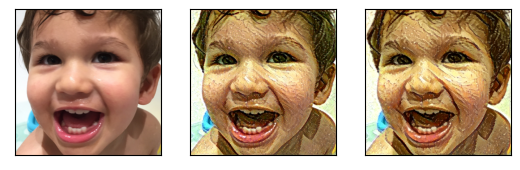

In [10]:
# 顯示原圖及結果
import matplotlib.pyplot as plt

image = plt.imread('./images/input.jpg')
plt.subplot(131)
plt.imshow(image)
plt.xticks([])
plt.yticks([])

image = plt.imread('output_at_iteration_0.png')
plt.subplot(132)
plt.imshow(image)
plt.xticks([])
plt.yticks([])

image = plt.imread('output_at_iteration_1.png')
plt.subplot(133)
plt.imshow(image)
plt.xticks([])
plt.yticks([])

plt.show()